# Volumetric AE

In [1]:
from utils import *

import os
import datetime

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import sys
sys.path.append("/home/dongwonshin/Desktop/Open3D/build/lib")
from py3d import *

from VolumetricVAE import *

# %load_ext line_profiler

# Volumetric AE Model training

In [2]:
vol_ae = VolumetricAE(_kernel_size=3, _stride=1)
vol_ae = torch.nn.DataParallel(vol_ae, device_ids = range(torch.cuda.device_count()))
vol_ae.cuda()

DataParallel(
  (module): VolumetricAE(
    (encoder): Encoder(
      (conv3d_1): Conv3d(21, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool3d_1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3d_2): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool3d_2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3d_3): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool3d_3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (decoder): Decoder(
      (conv3d_1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (upsample_1): Upsample(scale_factor=2, mode=trilinear)
      (conv3d_2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (upsample_2): Upsample(scale_factor=2, mode=trilinear)
      (conv3d_3): Conv3d(128, 21, ker

In [4]:
# optimizer = optim.SGD(vol_ae.parameters(), lr=0.0001, momentum=0.99, weight_decay=5e-4)
optimizer = optim.Adam(vol_ae.parameters(), lr=0.0001)
class_weight = np.ones(21); class_weight[0]=0.01; class_weight = torch.Tensor(class_weight); class_weight = class_weight.cuda()
recon_loss_func = torch.nn.CrossEntropyLoss(weight=class_weight)

epoches = 300
data_range = 100

for epoch in range(epoches):
    for idx in range(data_range):
        comp_pcd = read_point_cloud("/home/dongwonshin/Desktop/subvolume_dataset_making/mesh_results2/%06d_complete.ply" % idx)
        voxel_volume, color_volume = pcd2voxel(comp_pcd)
        
        input_volume = colorvol2classidvol(color_volume)
        input_volume = np.expand_dims(input_volume, axis=0) # fake batch axis
        input_volume = torch.from_numpy(input_volume).float() 
        input_volume = Variable(input_volume).cuda()

        optimizer.zero_grad()
        
        output_volume = vol_ae.forward(input_volume)
        
        target_volume = colorvol2classidvol(color_volume, False)
        target_volume = np.expand_dims(target_volume, axis=0) # fake batch axis
        target_volume = torch.from_numpy(target_volume).long() 
        target_volume = Variable(target_volume).cuda()
        
        recon_loss = recon_loss_func(output_volume, target_volume)
        
        loss = recon_loss
        
        loss.backward()
        optimizer.step()

        l = loss.data[0]
    
    print(l)

    # save the intermediate result
    argmaxed = torch.argmax(output_volume,1)
    output_color_volume = classidvol2colorvol(argmaxed.cpu().numpy())
    viz_vvae_output(output_color_volume,'./result_image_volumetricae2',show=False,save=True)
    

/home/dongwonshin/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/dongwonshin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(2.8353, device='cuda:0')
tensor(2.8245, device='cuda:0')
tensor(2.4460, device='cuda:0')
tensor(2.3568, device='cuda:0')
tensor(2.3045, device='cuda:0')
tensor(2.2709, device='cuda:0')
tensor(2.2374, device='cuda:0')
tensor(2.2016, device='cuda:0')
tensor(2.1699, device='cuda:0')
tensor(2.1565, device='cuda:0')
tensor(2.1475, device='cuda:0')
tensor(2.1626, device='cuda:0')
tensor(2.1277, device='cuda:0')
tensor(2.1542, device='cuda:0')
tensor(2.1338, device='cuda:0')
tensor(2.1439, device='cuda:0')
tensor(2.1186, device='cuda:0')
tensor(2.1197, device='cuda:0')
tensor(2.1025, device='cuda:0')
tensor(2.0819, device='cuda:0')
tensor(2.0667, device='cuda:0')
tensor(2.0168, device='cuda:0')
tensor(2.0428, device='cuda:0')
tensor(2.0331, device='cuda:0')
tensor(2.0193, device='cuda:0')
tensor(2.0256, device='cuda:0')
tensor(2.0465, device='cuda:0')
tensor(2.0413, device='cuda:0')
tensor(2.0617, device='cuda:0')
tensor(2.0282, device='cuda:0')
tensor(2.0641, device='cuda:0')
tensor(2

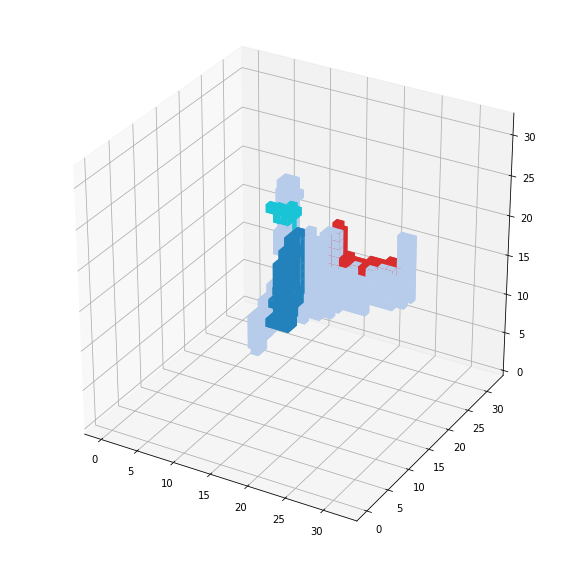

In [6]:
idx=10
comp_pcd = read_point_cloud("/home/dongwonshin/Desktop/subvolume_dataset_making/mesh_results2/%06d_complete.ply" % idx)
voxel_volume, color_volume = pcd2voxel(comp_pcd)
input_volume = colorvol2classidvol(color_volume)
target_volume = colorvol2classidvol(color_volume, False)

converted_color_volume = classidvol2colorvol(target_volume)
viz_vvae_output(converted_color_volume, divide=True)

In [10]:
np.iinfo(np.uint32)

iinfo(min=0, max=4294967295, dtype=uint32)